This notebook contains:
- Loading Sentinel-2 data and WorldCover data, and saving to a Zarr file using Dask
- Model and dataset definitions for an 11-class classification model based on the WorldCover dataset
- A training function using DDP and `dask_pytorch_ddp` to finetune Prithvi
- Various tests for each component

Most of the cells are fairly self-contained. I plan to clean up the implementation so it flows more cohesively and remove any repeated code.

Note:
- The training function has run successfully, but I have not yet evaluated the results
- The dataset is relatively small, so I can test it easily
- Most other components have been tested locally in isolation

Next steps (in rough order):
- Evaluate the finetuned model
- Create demo-friendly visualisations
- Clean up the notebook to make it more reusable and Argo-friendly
- Decide whether to expand the dataset
- Research efficiency improvements in both data loading and training
- Investigate skipping the S3 save step and training directly from the source data

In [1]:
# Common imports and settings
import os, sys, re
from pathlib import Path
from IPython.display import Markdown
import pandas as pd
pd.set_option("display.max_rows", None)
import xarray as xr
import dask
from dask.distributed import Client
from dask_gateway import Gateway
from dateutil.parser import parse
from dateutil.relativedelta import relativedelta

# Datacube
import datacube
from datacube.utils.aws import configure_s3_access
import odc.geo.xr                                  # https://github.com/opendatacube/odc-geo
from datacube.utils import masking  # https://github.com/opendatacube/datacube-core/blob/develop/datacube/utils/masking.py
from odc.algo import enum_to_bool                  # https://github.com/opendatacube/odc-tools/blob/develop/libs/algo/odc/algo/_masking.py
from dea_tools.plotting import display_map, rgb    # https://github.com/GeoscienceAustralia/dea-notebooks/tree/develop/Tools

import boto3

# Basic plots
%matplotlib inline
# import matplotlib.pyplot as plt
# plt.rcParams['figure.figsize'] = [12, 8]

# Holoviews
# https://holoviz.org/tutorial/Composing_Plots.html
# https://holoviews.org/user_guide/Composing_Elements.html
import hvplot.pandas
import hvplot.xarray
import panel as pn
import colorcet as cc
import cartopy.crs as ccrs
from datashader import reductions
from holoviews import opts
# hv.extension('bokeh', logo=False)
print("Libraries loaded successfully.")

Libraries loaded successfully.


In [2]:
# EASI defaults
# These are convenience functions so that the notebooks in this repository work in all EASI deployments

# The `git.Repo()` part returns the local directory that easi-notebooks has been cloned into
# If using the `easi-tools` functions from another path, replace `repo` with your local path to `easi-notebooks` directory
try:
    import git
    repo = git.Repo('.', search_parent_directories=True).working_tree_dir    # Path to this cloned local directory
except (ImportError, git.InvalidGitRepositoryError):
    repo = Path.home() / 'easi-notebooks'    # Reasonable default
    if not repo.is_dir():
        raise RuntimeError('To use `easi-tools` please provide the local path to `https://github.com/csiro-easi/easi-notebooks`')
if repo not in sys.path:
    sys.path.append(str(repo))    # Add the local path to `easi-notebooks` to python

from easi_tools import EasiDefaults
from easi_tools import initialize_dask, xarray_object_size, mostcommon_crs, heading
#from easi_tools.load_s2l2a import load_s2l2a_with_offset
print("EASI librariies loaded successfully.")

EASI librariies loaded successfully.


In [3]:
# easi = EasiDefaults()
# bucket = easi.scratch
# userid = boto3.client('sts').get_caller_identity()['UserId']
# project_name = "training_test_project"
# dataset_name = "training_dataset_v2.zarr"
# s3_path = f"s3://{bucket}/{userid}/{project_name}/{dataset_name}"
# print(f"Target Storage Path: {s3_path}")

# Dask Setup

In [ ]:
gateway = Gateway()
options = gateway.cluster_options()
# To get GPUs you must specify 
options.cuda_worker = True
clusters = gateway.list_clusters()
if not clusters:
    print('Creating new cluster...')
    cluster = gateway.new_cluster(cluster_options=options)
else:
    print(f'Connecting to existing cluster: {clusters[0].name}')
    cluster = gateway.connect(clusters[0].name)

NUM_WORKERS = 4
cluster.scale(NUM_WORKERS)
client = cluster.get_client()

print("Cluster Dashboard:", client.dashboard_link)

In [29]:
configure_s3_access(aws_unsigned=False, requester_pays=True, client=client);

# Data Prep

In [6]:
import planetary_computer
from pystac_client import Client as PClient
import odc.stac
import xarray as xr
import numpy as np
import boto3
import dask
from easi_tools import EasiDefaults
import warnings
warnings.filterwarnings('ignore')


# === S3 SETUP ===
easi = EasiDefaults()
bucket = easi.scratch
userid = boto3.client('sts').get_caller_identity()['UserId']
project_name = "training_test_project"
dataset_name = "training_dataset_v3.zarr"
s3_path = f"s3://{bucket}/{userid}/{project_name}/{dataset_name}"
print(f"Target Storage Path: {s3_path}")

# === CONFIGURATION ===
locations = {
    "tasmania_forest":   [146.5, -42.0, 146.7, -41.8],
    "vic_agriculture":   [143.5, -37.0, 143.7, -36.8],
    "nsw_coast":         [150.8, -34.5, 151.0, -34.3],
    "qld_tropical":      [145.7, -16.5, 145.9, -16.3],
    "wa_arid":           [116.0, -32.0, 116.2, -31.8]
}

seasonal_windows = [
    "2021-01-01/2021-02-28",
    "2021-06-01/2021-07-31",
    "2021-09-01/2021-10-31"
]

bands_s2 = ["B02", "B03", "B04", "B8A", "B11", "B12", "SCL"]
band_names = ["blue", "green", "red", "nir", "swir1", "swir2"]

resolution = 20
output_crs = "EPSG:3577"

catalog = PClient.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace
)



#   PROCESS ONE LOCATION 
def process_location(loc_name, bbox):
    try:
        # -- Load labels --
        label_items = catalog.search(
            collections=["esa-worldcover"],
            bbox=bbox
        ).item_collection()

        labels = odc.stac.load(
            label_items,
            bands=["map"],
            bbox=bbox,
            chunks={"x": 512, "y": 512},
            resolution=resolution,
            crs=output_crs,
            resampling="nearest",
            fail_on_error=False
        )
        target_geobox = labels.odc.geobox

        # Load seasonal
        composites = []

        for time_range in seasonal_windows:

            s2_items = catalog.search(
                collections=["sentinel-2-l2a"],
                bbox=bbox,
                datetime=time_range,
                query={"eo:cloud_cover": {"lt": 90}}
            ).item_collection()

            if not s2_items:
                return None

            ds = odc.stac.load(
                s2_items,
                bands=bands_s2,
                geobox=target_geobox,
                chunks={"x": 512, "y": 512},
                fail_on_error=False
            )

            # Skip empty results
            if ds.sizes.get("time", 0) == 0:
                return None

            # Cloud-clean composite
            if "SCL" in ds:
                qa = ds["SCL"]
                valid = (qa == 4) | (qa == 5) | (qa == 6) | (qa == 7) | (qa == 2) | (qa == 11)
                masked = ds.where(valid)
                comp = masked.median(dim="time")
                comp = comp.fillna(masked.min(dim="time")).fillna(0)
            else:
                comp = ds.median(dim="time").fillna(0)

            composites.append(comp)

        if len(composites) != 3:
            return None

        stacked = xr.concat(composites, dim="time")

        # Select only bands needed
        features = stacked[["B02", "B03", "B04", "B8A", "B11", "B12"]]
        features = features.rename({
            "B02": "blue",
            "B03": "green",
            "B04": "red",
            "B8A": "nir",
            "B11": "swir1",
            "B12": "swir2"
        })

        features = features.astype("uint16")
        features = features.to_array(dim="band").transpose("band", "time", "y", "x")

        labels_da = labels["map"].isel(time=0, drop=True)
        labels_da = labels_da.fillna(255).astype("uint8")

        return xr.Dataset({
            "features": features,
            "labels": labels_da
        })

    except Exception as e:
        print(f"[{loc_name}] ERROR: {e}")
        return None


print("\nBuilding computation graph...")

lazy = []
for loc_name, bbox in locations.items():
    print(f"  Adding: {loc_name}")
    lazy.append(dask.delayed(process_location)(loc_name, bbox))



#   EXECUTE
print("\nExecuting distributed jobs...")
results = dask.compute(*lazy)

valid = [ds for ds in results if ds is not None]

print(f"Processed {len(valid)} / {len(locations)}")

if not valid:
    raise RuntimeError("No valid samples produced.")



#   COMBINE SAMPLES
combined = []

for i, ds in enumerate(valid):
    ds = ds.reset_coords(drop=True)
    ds = ds.expand_dims(sample=[i])# fix: sample is NEW dimension
    combined.append(ds)

ds_final = xr.concat(combined, dim="sample")

# Recommended chunking for DL + Prithvi chunck requirements
ds_final = ds_final.chunk({
    "sample": 1,
    "time": -1,
    "band": -1,
    "y": 224,
    "x": 224
})

# Metadata
ds_final.attrs["n_samples"] = len(valid)
ds_final.attrs["n_time_steps"] = 3
ds_final.attrs["bands"] = band_names

print("\nFinal dataset:")
print(ds_final)

#   SAVE TO ZARR
print(f"Writing to: {s3_path}")
ds_final.to_zarr(s3_path, mode="w", consolidated=True)

print("\n[DONE]")


Successfully found configuration for deployment "csiro"
Target Storage Path: s3://easihub-csiro-user-scratch/AROAWO7MSC2T2SINGSYOQ:csiro-csiro-aad_gre555@csiro.au/training_test_project/training_dataset_v3.zarr

Building computation graph...
  Adding: tasmania_forest
  Adding: vic_agriculture
  Adding: nsw_coast
  Adding: qld_tropical
  Adding: wa_arid

Executing distributed jobs...
Processed 5 / 5


/tmp/ipykernel_112/817134267.py:177: FutureWarning: In a future version of xarray the default value for join will change from join='outer' to join='exact'. This change will result in the following ValueError: cannot be aligned with join='exact' because index/labels/sizes are not equal along these coordinates (dimensions): 'y' ('y',) The recommendation is to set join explicitly for this case.
  ds_final = xr.concat(combined, dim="sample")
/tmp/ipykernel_112/817134267.py:177: FutureWarning: In a future version of xarray the default value for join will change from join='outer' to join='exact'. This change will result in the following ValueError: cannot be aligned with join='exact' because index/labels/sizes are not equal along these coordinates (dimensions): 'x' ('x',) The recommendation is to set join explicitly for this case.
  ds_final = xr.concat(combined, dim="sample")
/env/lib/python3.12/site-packages/dask/array/core.py:4998: PerformanceWarning: Increasing number of chunks by factor


Final dataset:
<xarray.Dataset> Size: 12GB
Dimensions:   (sample: 5, band: 6, time: 3, y: 6036, x: 5288)
Coordinates:
  * y         (y) float64 48kB -4.664e+06 -4.664e+06 ... -1.813e+06 -1.813e+06
  * x         (x) float64 42kB -1.497e+06 -1.497e+06 ... 1.735e+06 1.735e+06
  * band      (band) object 48B 'blue' 'green' 'red' 'nir' 'swir1' 'swir2'
  * sample    (sample) int64 40B 0 1 2 3 4
Dimensions without coordinates: time
Data variables:
    features  (sample, band, time, y, x) float32 11GB dask.array<chunksize=(1, 6, 3, 224, 224), meta=np.ndarray>
    labels    (sample, y, x) float32 638MB dask.array<chunksize=(1, 224, 224), meta=np.ndarray>
Attributes:
    n_samples:     5
    n_time_steps:  3
    bands:         ['blue', 'green', 'red', 'nir', 'swir1', 'swir2']
Writing to: s3://easihub-csiro-user-scratch/AROAWO7MSC2T2SINGSYOQ:csiro-csiro-aad_gre555@csiro.au/training_test_project/training_dataset_v3.zarr


/env/lib/python3.12/site-packages/zarr/api/asynchronous.py:233: ZarrUserWarning: Consolidated metadata is currently not part in the Zarr format 3 specification. It may not be supported by other zarr implementations and may change in the future.
  warnings.warn(
/env/lib/python3.12/site-packages/distributed/client.py:3363: UserWarning: Sending large graph of size 151.66 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(



[DONE]


In [8]:
import xarray as xr
import s3fs
# s3_path should still be defined from your saving script

fs = s3fs.S3FileSystem()
store = s3fs.S3Map(root=s3_path, s3=fs, check=False)
ds_check = xr.open_dataset(store, engine='zarr', chunks={})
print("--- Zarr Dataset Structure Loaded by Verification Code ---")
print(ds_check)

NameError: name 's3_path' is not defined

Successfully found configuration for deployment "csiro"
Target Storage Path: s3://easihub-csiro-user-scratch/AROAWO7MSC2T2SINGSYOQ:csiro-csiro-aad_gre555@csiro.au/training_test_project/training_dataset_v3.zarr
⏳ Verifying Saved Data at: s3://easihub-csiro-user-scratch/AROAWO7MSC2T2SINGSYOQ:csiro-csiro-aad_gre555@csiro.au/training_test_project/training_dataset_v3.zarr
Dataset loaded. Dimensions:
  Samples (N): 5
  Time Steps (T): 3
  Spatial (Y, X): 6036, 5288
  Bands: ['blue', 'green', 'red', 'nir', 'swir1', 'swir2']
DEBUG: Sample 0 unique label values: [10. 30. 50. 60. 80. 90. nan]
Processing Sample 0...
DEBUG: Sample 1 unique label values: [10. 30. 40. 50. 60. 80. nan]
Processing Sample 1...
DEBUG: Sample 2 unique label values: [10. 20. 30. 40. 50. 60. 80. 90. nan]
Processing Sample 2...
DEBUG: Sample 3 unique label values: [80. nan]
Processing Sample 3...
DEBUG: Sample 4 unique label values: [10. 20. 30. 40. 50. 60. 80. 90. nan]
Processing Sample 4...


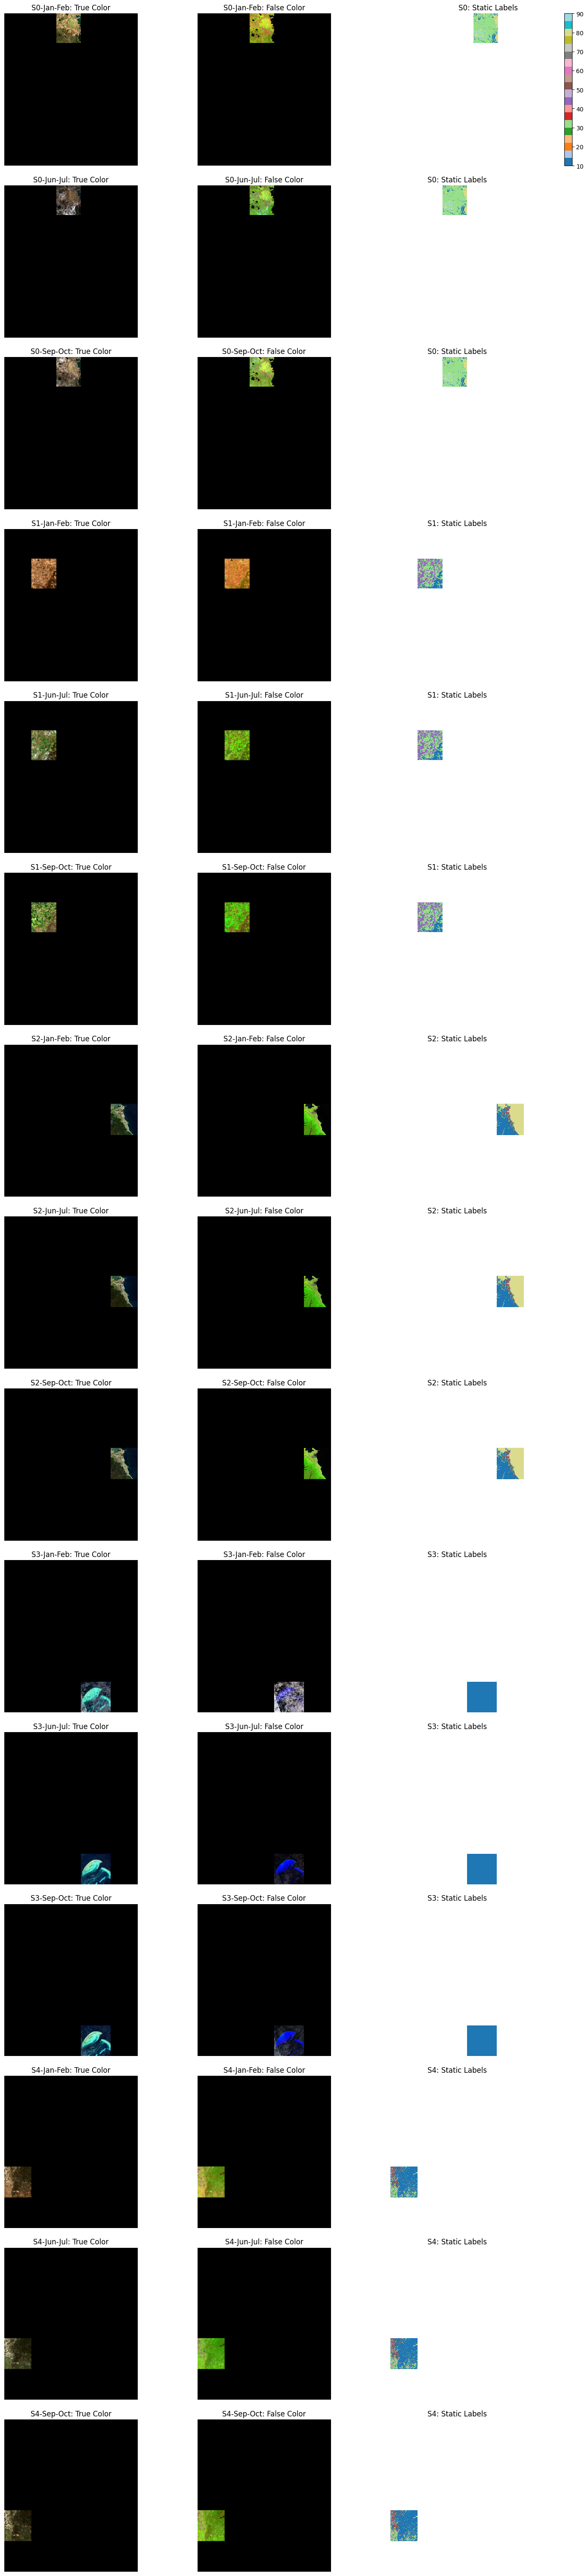

In [8]:
# Basic testing script to see that saving the data worked, TODO: use hvplot for better efficiency
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import s3fs
import dask.distributed

# --- CONFIGURATION ---
easi = EasiDefaults()
bucket = easi.scratch
userid = boto3.client('sts').get_caller_identity()['UserId']
project_name = "training_test_project"
dataset_name = "training_dataset_v3.zarr"
s3_path = f"s3://{bucket}/{userid}/{project_name}/{dataset_name}"
print(f"Target Storage Path: {s3_path}")
s3_zarr_path = s3_path # Ensure this variable is accessible/set

print(f"⏳ Verifying Saved Data at: {s3_zarr_path}")

# --- 1. Load Data ---
# Use Dask for loading to match the environment, although 'chunks={}' will load
# the metadata and index the chunks for all workers.
try:
    # Set up S3 access
    fs = s3fs.S3FileSystem()
    store = s3fs.S3Map(root=s3_zarr_path, s3=fs, check=False)
    
    # Open the multi-sample Zarr store. 'chunks={}' loads the full dataset chunks
    # lazily without combining them into a single dask chunk.
    ds = xr.open_dataset(store, engine='zarr', chunks={}) 
except Exception as e:
    print(f"⚠️ Error loading Zarr: {e}")
    raise

features = ds['features']
labels = ds['labels']

num_samples = ds.sizes.get('sample')
n_time_steps = ds.sizes.get('time')

if num_samples is None or n_time_steps != 3:
    print("\n❌ CRITICAL ERROR: The loaded Zarr file still does NOT contain the 'sample' dimension or the correct 'time' size (3).")
    print("Please re-run the data generation pipeline to ensure the correct multi-sample Zarr is saved before proceeding.")
    # Exit or raise an exception to prevent training on bad data
    raise KeyError("Loaded Zarr file is structurally incorrect. Expected dimensions 'sample' and 'time' size 3.")

print(f"Dataset loaded. Dimensions:")
print(f"  Samples (N): {num_samples}")
print(f"  Time Steps (T): {n_time_steps}")
print(f"  Spatial (Y, X): {features.sizes['y']}, {features.sizes['x']}")

# --- 2. Config & Helpers ---
# Band names are now coordinates thanks to the saving logic
band_names = ds.attrs["bands"] # Retrieve band names from dataset attributes
print(f"  Bands: {band_names}")

def get_rgb(data_array, bands_list):
    """
    Extracts bands for RGB from a DataArray, assuming the order (B, T, Y, X).
    """
    stack = []
    
    # 1. Extraction (Still the same, but now operating on the first dim B)
    for b in bands_list:
        # Select band across all time steps (Output shape: (T, Y, X))
        band_data = data_array.sel(band=b)  
        stack.append(band_data)
        
    # Stack along a new 'color' dimension. Output shape: (Color, T, Y, X)
    img = xr.concat(stack, dim="color").values.astype('float32')

    # 2. DN Scaling Correction (Scale from uint16 DNs to 0.0-1.0 float range)
    img = img / 10000.0
    img = np.nan_to_num(img, nan=0.0)
    
    # 3. Final Transpose: (Color, T, Y, X) -> (T, Y, X, Color) for plotting
    # Plotting requires (Time, Height, Width, Color)
    img = np.transpose(img, (1, 2, 3, 0)) 
    
    # Check if all images are empty (all zeros)
    if img.max() == 0:
        return None 
        
    # Contrast Stretch - apply stretching to each time step independently
    # The loop is now simpler as 'img' is already (T, Y, X, Color)
    for t in range(img.shape[0]):
        time_slice = img[t, :, :, :]
        valid_pixels = time_slice[time_slice > 0]
        
        if valid_pixels.size > 0:
            p2, p98 = np.percentile(valid_pixels, (2, 98))
            if p98 > p2:
                img[t, :, :, :] = (time_slice - p2) / (p98 - p2)
                        
    return np.clip(img, 0, 1)

# --- 3. Dynamic Plotting Loop ---

# Iterate over SAMPLES, not time steps.
rows = num_samples * n_time_steps 
cols = 3 # RGB, False Color, Labels

plt.figure(figsize=(15, 4 * rows))

plot_idx = 1
season_names = ["Jan-Feb", "Jun-Jul", "Sep-Oct"] # Names from seasonal_windows

for s in range(num_samples):
    # Select a single sample and compute its features and label.
    # .compute() here will read data off S3, potentially distributively if
    # the dask client is still running, which is appropriate for verification.
    sample_features = features.isel(sample=s).compute()
    sample_label = labels.isel(sample=s).compute()
    # Since the labels are static per sample (no 'time' dimension), we plot it once
    label_np = sample_label.values
    
    # 🚨 DEBUGGING STEP: Print unique values
    unique_vals = np.unique(label_np)
    print(f"DEBUG: Sample {s} unique label values: {unique_vals}")
    # ----------------------------------------
    # Check for valid data across all time steps in this sample
    # (Checking the max of the entire sample array is a quick check)
    if sample_features.values.max() == 0:
        print(f"⚠️ Sample {s} appears empty (all zeros). Skipping.")
        continue

    # Process all time steps for this sample
    print(f"Processing Sample {s}...")

    # Generate Images for all time steps at once
    # rgb_stack: (T, Y, X, Color)
    rgb_stack = get_rgb(sample_features, ['red', 'green', 'blue'])
    fc_stack  = get_rgb(sample_features, ['swir1', 'nir', 'red'])

    if rgb_stack is None:
        print(f"⚠️ Skipping Sample {s}: RGB stack failed.")
        continue
    
    # Since the labels are static per sample (no 'time' dimension), we plot it once
    label_np = sample_label.values
    
    for t in range(n_time_steps):
        time_name = season_names[t] if t < len(season_names) else f"Time {t}"
        
        # Plot RGB
        ax1 = plt.subplot(rows, cols, plot_idx)
        ax1.imshow(rgb_stack[t, :, :, :])
        ax1.set_title(f"S{s}-{time_name}: True Color")
        ax1.axis('off')
        plot_idx += 1

        # Plot False Color
        ax2 = plt.subplot(rows, cols, plot_idx)
        ax2.imshow(fc_stack[t, :, :, :])
        ax2.set_title(f"S{s}-{time_name}: False Color")
        ax2.axis('off')
        plot_idx += 1

        # Plot Labels (Only plot on the last column, which should be the same for all time steps)
        ax3 = plt.subplot(rows, cols, plot_idx)
        
        # The labels (WorldCover) are 2D (Y, X), but we repeat the plot for each time step for alignment.
        # Mask out background (0) and nodata (255) for better visualization.
        masked_lbl = np.ma.masked_where(label_np == 255, label_np)
        
        # We need a new colormap instance for consistency if plotting multiple times
        im = ax3.imshow(masked_lbl, cmap='tab20', interpolation='nearest')
        
        # Add colorbar only once for the entire set of label plots (e.g., first time step of the first sample)
        if s == 0 and t == 0: 
            plt.colorbar(im, fraction=0.046, pad=0.04)
            
        # Title only needs to be "Labels" once, or be more specific
        ax3.set_title(f"S{s}: Static Labels")
        ax3.axis('off')
        plot_idx += 1

plt.tight_layout()
plt.show()

In [6]:
from datacube.utils.aws import configure_s3_access
easi = EasiDefaults()
bucket = easi.scratch
userid = boto3.client('sts').get_caller_identity()['UserId']
project_name = "training_test_project"
dataset_name = "training_dataset_v3.zarr"
s3_path = f"s3://{bucket}/{userid}/{project_name}/{dataset_name}"
print(f"Target Storage Path: {s3_path}")
s3_zarr_path = s3_path # Ensure this variable is accessible/set
configure_s3_access(aws_unsigned=False, requester_pays=True, client=client)

Successfully found configuration for deployment "csiro"
Target Storage Path: s3://easihub-csiro-user-scratch/AROAWO7MSC2T2SINGSYOQ:csiro-csiro-aad_gre555@csiro.au/training_test_project/training_dataset_v3.zarr


In [34]:
client.close()
cluster.shutdown()

# Fine Tuning Setup

In [7]:
import torch
import torch.nn as nn
from terratorch.registry import BACKBONE_REGISTRY

class PrithviSegmentation(nn.Module):
    def __init__(self, num_classes=11):
        super().__init__()
        
        # 1. Use the V2 backbone (300M version)
        # We explicitly set num_frames=1 for standard static segmentation
        self.encoder = BACKBONE_REGISTRY.build(
            "prithvi_eo_v2_300", 
            pretrained=True,
            num_frames=3  
        )
        
        # 2. Update embed_dim to 1024 (standard for Prithvi-300M / ViT-Large)
        self.embed_dim = 1024
        
        self.decoder = nn.Sequential(
            nn.Conv2d(self.embed_dim, 512, kernel_size=3, padding=1), # Increased to 512
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),
            nn.Conv2d(512, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),
            nn.Conv2d(256, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Upsample(scale_factor=4, mode='bilinear', align_corners=False),
            nn.Conv2d(128, num_classes, kernel_size=1)
        )

    def forward(self, x):
        assert x.dim() == 5
        B, C, T, H, W = x.shape          # remember input H,W
    
        features = self.encoder(x)
        if isinstance(features, (list, tuple)):
            features = features[-1]
    
        if features.dim() == 3:
            if features.shape[1] % 2 != 0:
                features = features[:, 1:, :]
            B2, L, C2 = features.shape
            H_grid, W_grid = 21, 28
            features = features.permute(0, 2, 1).view(B2, C2, H_grid, W_grid)
    
        logits = self.decoder(features)  # (B, num_classes, h’, w’)
    
        # force back to input spatial size
        logits = nn.functional.interpolate(
            logits, size=(H, W), mode="bilinear", align_corners=False
        )
        return logits


In [8]:
# # Test for dataset design
# model = BACKBONE_REGISTRY.build("prithvi_eo_v2_300", pretrained=True, num_frames=3)
# x_dummy = torch.randn(2, 6, 3, 224, 224)  # B=2, C=6 bands, T=3, H=W=224
# out = model(x_dummy)
# print(type(out))
# if isinstance(out, (list, tuple)):
#     for i, o in enumerate(out):
#         print(i, o.shape)
# else:
#     print(out.shape)


In [9]:
import numpy as np
class WorldCoverZarrDataset(torch.utils.data.Dataset):
    def __init__(self, zarr_path, patch_size=224, num_classes=11,
                 transform=None, target_transform=None):
        self.ds = xr.open_zarr(zarr_path, consolidated=True)
        self.n_samples = self.ds.sizes["sample"]
        self.patch_size = patch_size
        self.num_classes = num_classes
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return self.n_samples

    def __getitem__(self, idx):
        sample = self.ds.isel(sample=idx)
        x = sample["features"].values   # (band, time, y, x)
        y = sample["labels"].values     # (y, x), float32


        # map WorldCover codes to 0..N-1
        code_map = {
            10: 0,
            20: 1,
            30: 2,
            40: 3,
            50: 4,
            60: 5,
            70: 6,
            80: 7,
            90: 8,
            95: 9,
            100: 10
            # add others you care about
        }
        
        H, W = y.shape
        ph = pw = self.patch_size
        i = np.random.randint(0, H - ph + 1)
        j = np.random.randint(0, W - pw + 1)

        x = x[..., i:i+ph, j:j+pw]
        y = y[i:i+ph, j:j+pw]
        y_mapped = np.full_like(y, fill_value=255, dtype=np.int64)  # ignore by default
        for wc_code, cls_idx in code_map.items():
            y_mapped[y == wc_code] = cls_idx
        # clean labels
        y_mapped[np.isnan(y)] = 255      # set NaN to 255 (ignore)
        y = y_mapped
        y = y.astype(np.int64)

        # mark anything outside [0, num_classes-1] as ignore

        x = torch.from_numpy(x).float()        # (C, T, H, W)
        y = torch.from_numpy(y).long()         # (H, W)

        if self.transform:
            x = self.transform(x)
        if self.target_transform:
            y = self.target_transform(y)

        return x, y


# Fine Tuning

In [10]:

# easi = EasiDefaults()
# bucket = easi.scratch
# userid = boto3.client('sts').get_caller_identity()['UserId']
# project_name = "training_test_project"
# dataset_name = "training_dataset_v3.zarr"
# s3_path = f"s3://{bucket}/{userid}/{project_name}/{dataset_name}"
# print(f"Target Storage Path: {s3_path}")

# ds = WorldCoverZarrDataset(s3_path)
# x, y = ds[0]
# print("x:", x.shape, x.dtype)  # expect (6, 3, 224, 224)
# print("y:", y.shape, y.dtype)  # expect (224, 224)

# model = PrithviSegmentation(num_classes=11)
# out = model(x.unsqueeze(0))    # (1, 6, 3, 224, 224)
# print("out:", out.shape)       # expect (1, 11, ~224, ~224)

# loss_fn = nn.CrossEntropyLoss(ignore_index=255)
# loss = loss_fn(out, y.unsqueeze(0))
# loss.backward()


In [11]:
# ds = WorldCoverZarrDataset(s3_path)
# for i in range(len(ds)):
#     _, y_i = ds[i]
#     vals, counts = torch.unique(y_i, return_counts=True)
#     print(i, dict(zip(vals.tolist(), counts.tolist())))


In [ ]:
# based on A's work
def train(zarr_path, s3_bucket, output_dir, log_dir, checkpoint_file=None):

    start_epoch= 0
    num_epochs = 10
    batch_size = 100 
    learning_rate = 0.001

    worker_rank = int(dist.get_rank())
    device = torch.device(0)
    
    #Dataset
    train_ds = WorldCoverZarrDataset(zarr_path, patch_size=224, num_classes=11)
    val_ds   = WorldCoverZarrDataset(zarr_path, patch_size=224, num_classes=11)

    sampler_train = DistributedSampler(train_ds)
    sampler_val   = DistributedSampler(val_ds)

    traingen = DataLoader(train_ds, batch_size=batch_size, sampler=sampler_train, shuffle=False)
    valgen   = DataLoader(val_ds,   batch_size=batch_size, sampler=sampler_val, shuffle=False)
    
    val_loss_min = np.Inf
    
    # pass to GPU device -> wrapped in DDP then it can communicate with the other workers
    model = PrithviSegmentation(num_classes=11)
    model = model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    model = DDP(model, device_ids=[0])
    model_without_ddp = model.module
    
    loss_function = nn.CrossEntropyLoss(ignore_index=255)
    ''' TODO: Set up checkpoint system
    if checkpoint_file:
        checkpoint_connection = S3Checkpoint(region='ap-southeast-2')
        # load best saved model checkpoint from previous commit (if present)
        with checkpoint_connection.reader("f"s3://{bucket}/{userid}/{project_name}/"+checkpoint_file) as reader:
            checkpoint = torch.load(reader)
        model_without_ddp.load_state_dict(checkpoint['model'])
        optimizer.load_state_dict(checkpoint['optimizer'])
        start_epoch = checkpoint['epoch'] + 1
        val_loss_min =checkpoint['val_loss_min']
        '''
    for epoch in range(start_epoch, num_epochs):
        log={}
        log.update({"worker_rank":worker_rank, "epoch":epoch, "start_time":datetime.now().isoformat()})
        
        train_accuracy = 0
        train_loss = 0
        val_accuracy = 0
        val_loss = 0
        
        sampler_train.set_epoch(epoch)
        sampler_val.set_epoch(epoch)
        # #Training
        model.train()
        for inputs, labels in traingen:
            inputs = inputs.to(device)# (B, 6, 3, 224, 224)
            labels = labels.to(device)# (B, 224, 224)
    
            optimizer.zero_grad()
            outputs = model(inputs)# (B, 11, 224, 224)
            # pixel accuracy (ignoring 255)
            with torch.no_grad():
                preds = outputs.argmax(dim=1)# (B, H, W)
                valid = labels != 255
                correct = (preds[valid] == labels[valid]).sum().item()
                total = valid.sum().item()
                acc = correct / max(total, 1)
    
            loss = loss_function(outputs, labels)
            loss.backward()
            optimizer.step()
    
            train_loss += loss.item()
            train_accuracy += acc
        
        log.update({
            "train_loss": float(train_loss),
            "train_accuracy": float(train_accuracy),
            "end_time_train": datetime.now().isoformat(),
        })
    
        # --- VAL ---
        model.eval()
        with torch.no_grad():
            for inputs, labels in valgen:
                inputs = inputs.to(device)
                labels = labels.to(device)
    
                outputs = model(inputs)
    
                preds = outputs.argmax(dim=1)
                valid = labels != 255
                correct = (preds[valid] == labels[valid]).sum().item()
                total = valid.sum().item()
                acc = correct / max(total, 1)
    
                loss = loss_function(outputs, labels)
                val_loss += loss.item()
                val_accuracy += acc
        
        log.update({
            "val_loss": float(val_loss),
            "val_accuracy": float(val_accuracy),
            "end_time_val": datetime.now().isoformat(),
        })
    
        dist.barrier()
        if worker_rank == 0:
            log_file = log_dir + f"log_epoch_{epoch}.json"
            boto3.client("s3").put_object(
                Body=json.dumps(log),
                Bucket=s3_bucket,
                Key=log_file,
            )
            if val_loss < val_loss_min:
                val_loss_min = val_loss
                output_file=output_dir+ 'model_{}.pth'.format(epoch)
                checkpoint_connection = S3Checkpoint(region='ap-southeast-2')
                checkpoint = {'model': model_without_ddp.state_dict(), 'optimizer': optimizer.state_dict(),'epoch': epoch, 'val_loss_min':val_loss_min}
                with checkpoint_connection.writer(f"s3://{bucket}/{userid}/{project_name}/"+output_file) as writer:
                    torch.save(checkpoint, writer)

    return

In [ ]:
print("Installing dask-pytorch-ddp on all workers...")
client.run(lambda: exec("import sys; import subprocess; subprocess.check_call([sys.executable, '-m', 'pip', 'install', 'dask-pytorch-ddp'])"))

# 2. Install on the Scheduler (This is the crucial missing step)
print("Installing dask-pytorch-ddp on the Scheduler...")
client.run_on_scheduler(lambda: exec("import sys; import subprocess; subprocess.check_call([sys.executable, '-m', 'pip', 'install', 'dask-pytorch-ddp'])"))

print("Installation initiated on both Scheduler and Workers. Now retry the DDP run.")


In [ ]:
from dask_pytorch_ddp import dispatch
from torch.nn.parallel import DistributedDataParallel as DDP
from torch.utils.data.distributed import DistributedSampler
from torch import nn
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import torch.multiprocessing as mp
import torch.optim as optim
from datetime import datetime, timedelta
import json
import torch.distributed as dist

client.restart()
zarr_path = s3_path
bucket_name = easi.scratch  # "easihub-csiro-user-scratch"
log_dir = f"{userid}/{project_name}/logs/"
output_dir = f"{userid}/{project_name}/models/"

futs = dispatch.run(
    client,
    train,
    zarr_path=zarr_path,
    s3_bucket=bucket_name,
    output_dir=output_dir,
    log_dir=log_dir,
)
results = client.gather(futs)


# Results

In [ ]:
# TODO: Results + Copy over docs